# libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import requests
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# fetching data

In [2]:
# These are the URLs for IMDb's datasets
imdb_com = 'https://datasets.imdbws.com/'
urls = {'name':'name.basics.tsv.gz',
        'title_aka':'title.akas.tsv.gz',
        'title':'title.basics.tsv.gz',
        'crew':'title.crew.tsv.gz',
        'principals':'title.principals.tsv.gz',
        'ratings':'title.ratings.tsv.gz'}
urls_list = list(urls)
urls_values = list(urls.values())

# fetching the files, unzipping them, and making a dataframe
name_f = requests.get((imdb_com + urls_values[0]))
open(urls_values[0], 'wb').write(name_f.content)
with gzip.open(urls_values[0]) as x:
    df_name = pd.read_csv(x, sep='\t')
# bullshit
title_aka_f = requests.get((imdb_com + urls_values[1]))
open(urls_values[1], 'wb').write(title_aka_f.content)
with gzip.open(urls_values[1]) as x:
    df_title_aka = pd.read_csv(x, sep='\t')
# I swear I wanted to create a function
title_f = requests.get((imdb_com + urls_values[2]))
open(urls_values[2], 'wb').write(title_f.content)
with gzip.open(urls_values[2]) as x:
    df_title = pd.read_csv(x, sep='\t')
# I just couldn't figure it out
crew_f = requests.get((imdb_com + urls_values[3]))
open(urls_values[3], 'wb').write(crew_f.content)
with gzip.open(urls_values[3]) as x:
    df_crew = pd.read_csv(x, sep='\t')
# something about creating a variable name by modifying the input...
principals_f = requests.get((imdb_com + urls_values[4]))
open(urls_values[4], 'wb').write(principals_f.content)
with gzip.open(urls_values[4]) as x:
    df_principals = pd.read_csv(x, sep='\t')
# s;dlfkas;dkfjas;dkfja;sldkfja;sdlkfja;sldkfjalook at my im codinga;sdlkf a;sdlkfja;slkd
ratings_f = requests.get((imdb_com + urls_values[5]))
open(urls_values[5], 'wb').write(ratings_f.content)
with gzip.open(urls_values[5]) as x:
    df_ratings = pd.read_csv(x, sep='\t')

# these are useless
df_title = df_title[df_title['titleType'].isin(['movie', 'tvMovie', 'tvSpecial'])]

# reading in a csv with my movies, their tconst, and a personal rating
df_collin = pd.read_csv('https://docs.google.com/spreadsheets/d/1C5fA7ID3iLk5Dp6h6HDebzmXvHvT0iumepx62feYD00/export?format=csv&id=1C5fA7ID3iLk5Dp6h6HDebzmXvHvT0iumepx62feYD00&gid=2115756143')

# then dropping columns I only needed so I can add movies easily in the future
df_collin = df_collin.drop(columns=['primaryTitle', 'startYear'])

# creating a list of tconst IDs for movies I've seen
seen_list = list(df_collin['tconst'])

# merging personal ratings with IMDb ratings
df_ratings = pd.merge(df_ratings, df_collin, how='left', on='tconst')

# creating a subset of each useful IMDb dataset with only the movies I've seen
seen_title = df_title[df_title['tconst'].isin(seen_list)]
seen_crew = df_crew[df_crew['tconst'].isin(seen_list)]
seen_ratings = df_ratings[df_ratings['tconst'].isin(seen_list)]
seen_principals = df_principals[df_principals['tconst'].isin(seen_list)]

seen_crew = seen_crew.reset_index()
seen_crew = seen_crew.drop(columns=['index'])

# just changing '\N' to 'not applicable'
for x in range(0, len(seen_crew['writers'])):
    if seen_crew['writers'][x] == '\\N':
        seen_crew['writers'][x] = 'not applicable'

C:\Users\colli\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\colli\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# functions

In [3]:
# list of all valid names
valid_names = list(df_name['nconst'])

# function to get the name from a person tconst
def get_name(name):
    if name in valid_names:
        actual_name = df_name.loc[(df_name['nconst'] == name)]['primaryName'].iloc[0]
    else: actual_name = name+'(??)'
    return actual_name

# function to get names of all nconsts in a list
def get_names(names):
    output = []
    for x in names:
        output.append(get_name(x))
    return output

# function to nconst of primary actors in a film tconst
def get_actors(title):
    title_df = df_principals.loc[(df_principals['category'].isin(['actor', 'actress']))
                        & (df_principals['tconst'] == title)]
    return list(title_df['nconst'])

# function to get nconst of primary directors in a film tconst
def get_directors(title):
    title_df = df_crew.loc[(df_crew['tconst'] == title)]
    return list(title_df['directors'])[0].split(',')

# function to get nconst of primary writers in a film tconst
def get_writers(title):
    title_df = df_crew.loc[(df_crew['tconst'] == title)]
    return list(title_df['writers'])[0].split(',')

# function to get the title from a film tconst
def get_title(title):
    actual_title = df_title.loc[(df_title['tconst'] == title)]['primaryTitle'].iloc[0]
    return actual_title

# encoding

In [4]:
# creating a dataframe with additional features from IMDb (writers, directors...)
seen_title_expanded = pd.merge(seen_title, seen_crew, on='tconst')
seen_title_expanded = seen_title_expanded.drop(columns=['originalTitle', 'titleType', 'writers'])

# creating a list inside each cell so I can use the get_names function
for x in range(0, len(seen_title_expanded['directors'])):
    seen_title_expanded['directors'][x] = seen_title_expanded['directors'][x].split(',')
    
# changing all name IDs to real names
for x in range(0, len(seen_title_expanded['directors'])):
    if seen_title_expanded['directors'][x][0][0:2] == 'nm':
        seen_title_expanded['directors'][x] = get_names(seen_title_expanded['directors'][x])
        
### genres ###

# creating a list of all genres I've seen
all_genres = pd.Series(str(list(seen_title_expanded['genres'])).replace('\'', '').replace(' ', '').replace(',', ' ').strip('[]').split(' '))

# creating a column for each unique genre
for x in all_genres.unique():
    seen_title_expanded[x] = pd.Series([0] * all_genres.nunique() * len(seen_title_expanded['genres']))

# creating a list in each cell so I can index the genres
for x in range(0, len(seen_title_expanded['genres'])):
    seen_title_expanded['genres'][x] = seen_title_expanded['genres'][x].split(',')

# adding a 1 in each genre column for every movie that has that genre listed
for x in range(0, len(seen_title_expanded['genres'])):
    for y in range(0, len(seen_title_expanded['genres'][x])):
        z = seen_title_expanded['genres'][x][y]
        seen_title_expanded[z][x] = 1
        
### directors ###

# creating a list of all directors I've seen
all_directors = []
for x in range(0, len(seen_title_expanded['directors'])):
    for y in range(0, len(seen_title_expanded['directors'][x])):
        all_directors.append(seen_title_expanded['directors'][x][y])
all_directors = pd.Series(all_directors)
for x in all_directors.unique():
    seen_title_expanded[x] = pd.Series([0] * all_directors.nunique() * len(seen_title_expanded['directors']))

# adding a 1 in each genre column for every movie that has that director listed
for x in range(0, len(seen_title_expanded['directors'])):
    for y in range(0, len(seen_title_expanded['directors'][x])):
        z = seen_title_expanded['directors'][x][y]
        seen_title_expanded[z][x] = 1
        
# I did the same thing for writers but it wasn't very useful and I decided to leave it out

<ipython-input-4-9bd600dbced8>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seen_title_expanded['genres'][x] = seen_title_expanded['genres'][x].split(',')
<ipython-input-4-9bd600dbced8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seen_title_expanded[z][x] = 1
<ipython-input-4-9bd600dbced8>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seen_title_expanded[z][x] = 1


# modeling

baseline, baseline, baseline

In [5]:
baseline = round((seen_ratings['wasWorth'].value_counts(normalize=True)[1]), 2)
print(baseline)

0.74


In [6]:
# adding ratings features to the expanded dataframe
seen_title_expanded = pd.merge(seen_title_expanded, seen_ratings, on='tconst')
seen_title_expanded.index = seen_title_expanded['tconst']
seen_title_expanded = seen_title_expanded.drop(columns=['tconst', 'isAdult', 'endYear', 'primaryTitle', 'genres', 'directors', 'personalRating', 'seen'])
seen_title_expanded['startYear'] = seen_title_expanded['startYear'].astype(int)
seen_title_expanded['runtimeMinutes'] = seen_title_expanded['runtimeMinutes'].astype(int)
seen_title_expanded['wasWorth'] = seen_title_expanded['wasWorth'].astype(int)

In [7]:
# train, validate, test sets
test = seen_title_expanded.sample(70, random_state=49)
train_val = seen_title_expanded.drop(test.index)
val = train_val.sample(70, random_state=49)
train = train_val.drop(val.index)

X_train = train.drop(columns=['wasWorth', 'numVotes'])
y_train = train['wasWorth']

X_val = val.drop(columns=['wasWorth', 'numVotes'])
y_val = val['wasWorth']

X_test = test.drop(columns=['wasWorth', 'numVotes'])
y_test = test['wasWorth']

C:\Users\colli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\colli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\colli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\colli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

baseline: 0.74
random forest classifier: 0.7571428571428571


C:\Users\colli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\colli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

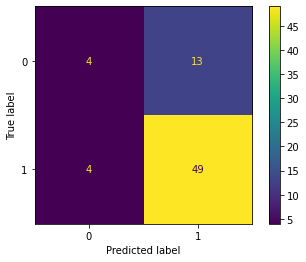

In [8]:
# Logistic Regression (cross validation)
quick_lr = LogisticRegressionCV(cv=5).fit(X_train, y_train)

print('baseline:', baseline)
print('random forest classifier:', quick_lr.score(X_val, y_val))

plot_confusion_matrix(quick_lr, X_val, y_val);

baseline: 0.74
decisino tree classifier: 0.7142857142857143


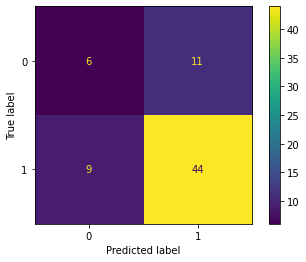

In [9]:
# Decision Tree Classifier
quick_dt = DecisionTreeClassifier(random_state=2).fit(X_train, y_train)

print('baseline:', baseline)
print('decisino tree classifier:', quick_dt.score(X_val, y_val))

plot_confusion_matrix(quick_dt, X_val, y_val);

baseline: 0.74
random forest classifier: 0.7714285714285715


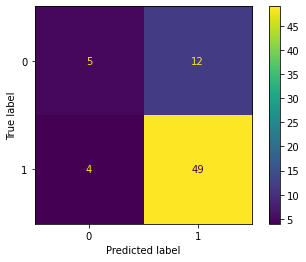

In [10]:
# Random Forest Classifier
quick_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)

print('baseline:', baseline)
print('random forest classifier:', quick_rf.score(X_val, y_val))
 
plot_confusion_matrix(quick_rf, X_val, y_val);

In [66]:
# classification report
y_pred = quick_rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.29      0.38        17
           1       0.80      0.92      0.86        53

    accuracy                           0.77        70
   macro avg       0.68      0.61      0.62        70
weighted avg       0.74      0.77      0.74        70



In [12]:
print('Chosen model test score:', quick_rf.score(X_test, y_test))

Chosen model test score: 0.8


# more evaluating

In [62]:
# checking feature importances
rf_imp = pd.DataFrame(X_train.columns)
rf_imp['importance'] = quick_rf.feature_importances_
rf_imp = rf_imp.sort_values(by=['importance'], ascending=True)
rf_imp_20 = rf_imp.tail(20)

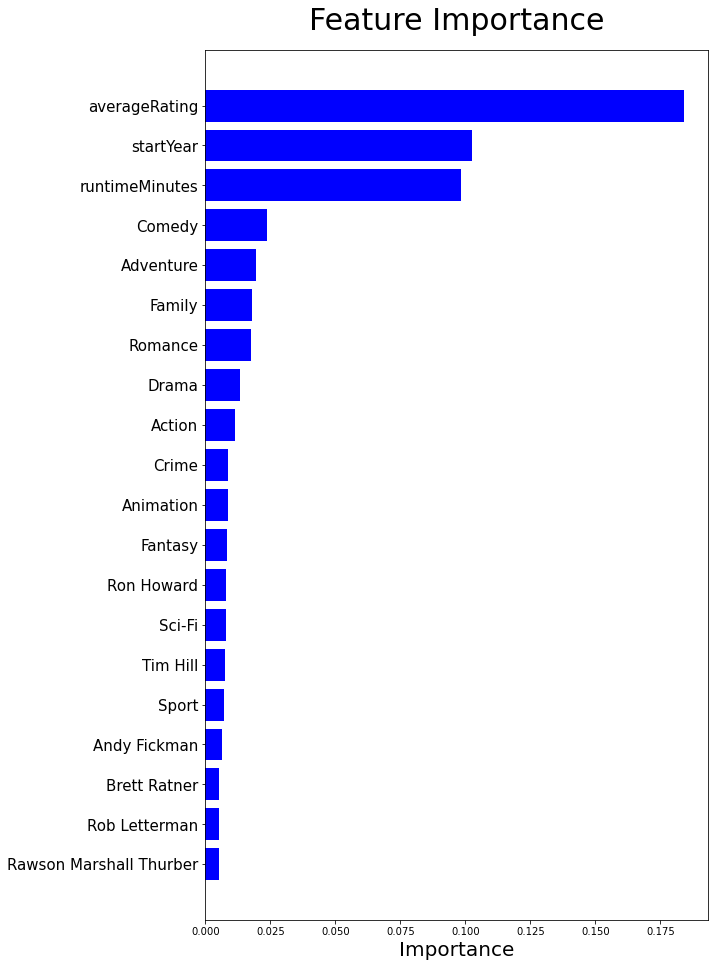

In [63]:
plt.subplots(figsize=(9, 16))
plt.title('Feature Importance', size=30, pad=20)
plt.barh(rf_imp_20[0], rf_imp_20['importance'], color='b', align='center')
plt.yticks(size=15)
plt.xlabel('Importance', size=20)
plt.show()

# bonus

In [14]:
# my top 50 movies I guess
top_50 = seen_ratings.sort_values(by='personalRating', ascending=False).head(50)['tconst']
names_50 = []
for x in top_50:
    names_50.append(get_title(x))
names_50

['Toy Story 2',
 'Casino Royale',
 'Star Wars: Episode VII - The Force Awakens',
 'The Dark Knight',
 'Tangled',
 'The Incredibles',
 'Interstellar',
 'Harry Potter and the Order of the Phoenix',
 'Avengers: Infinity War',
 'Curious George',
 'Toy Story 3',
 'Titanic',
 'Harry Potter and the Prisoner of Azkaban',
 'Cars',
 'Star Wars: Episode VIII - The Last Jedi',
 'Baby Driver',
 'La La Land',
 'Avengers: Endgame',
 'Toy Story',
 'Dawn of the Planet of the Apes',
 'Captain America: The Winter Soldier',
 'Black Panther',
 'How to Train Your Dragon 2',
 'WALL·E',
 'The Lego Movie',
 "Piglet's Big Movie",
 'Harry Potter and the Chamber of Secrets',
 'Skyfall',
 'Finding Nemo',
 "Harry Potter and the Sorcerer's Stone",
 '22 Jump Street',
 'Jurassic Park',
 'Django Unchained',
 'Toy Story 4',
 'Spider-Man: Into the Spider-Verse',
 "What's Eating Gilbert Grape",
 'Ratatouille',
 'Lilo & Stitch',
 'Edge of Tomorrow',
 'The Grand Budapest Hotel',
 'Como agua para chocolate',
 'Blade Runner 2